# Задача линейной регрессии

## 0. Подключение библиотек

In [1]:
import numpy as np
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import random 

## 1. Данные

### Вычисление корелляции

Формула Пирсона для счета корреляции
$$
r = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum (x_i - \bar{x})^2 \cdot \sum (y_i - \bar{y})^2}}
$$
Где:
- $ x_i $ и $ y_i $ — значения элементов массивов $ X $ и $ Y $.
- $ \bar{x} $ и $ \bar{y} $ — средние значения массивов $ X $ и $ Y $.

In [2]:
features_train = [] 
prices = []         

with open('./preprocessed_data.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    
    featuresTitles = { key: [] for key in reader.fieldnames if key != 'SalePrice' }
    salePrices = []
    
    for row in reader:
        try:
            salePrice = float(row['SalePrice'])
            salePrices.append(salePrice)
            
            for feature in featuresTitles:
                featuresTitles[feature].append(float(row[feature]))
        except ValueError:
            continue

salePrices = np.array(salePrices)
featuresTitles = { key: np.array(values) for key, values in featuresTitles.items() }

correlations = {}
for feature, values in featuresTitles.items():
    valid_indices = ~np.isnan(values) 
    if np.any(valid_indices):
        correlation = np.corrcoef(values[valid_indices], salePrices[valid_indices])[0, 1]
        correlations[feature] = abs(correlation) 

best_feature = max(correlations, key=correlations.get)
print(f"Лучший признак: {best_feature} (корреляция: {correlations[best_feature]:.5f})")

Лучший признак: OverallQual (корреляция: 0.81751)


### Считывание данных

In [3]:
# best_feature = 'LotArea'

with open('./preprocessed_data.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row[best_feature] == 'NA' or row['SalePrice'] == 'NA':
            continue
        
        best_feature_value = float(row[best_feature])
        sale_price = float(row['SalePrice'])
        
        features_train.append([best_feature_value])
        prices.append(sale_price)

features_train = np.array(features_train)
prices = np.array(prices)

x_train, x_test, y_train, y_test = train_test_split(
    features_train, prices, 
    test_size=0.3, 
    random_state=42
)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# noise_train = np.random.uniform(-0.1, 0.1, size=x_train.shape)  
# x_train += noise_train


### Визуализация данных

In [4]:
table_data = []
headers = ["Index", "Best correlation feature", "SalePrice"]

for i, (feat_scaled, price) in enumerate(zip(x_train, y_train)):
    table_data.append([
        i,
        feat_scaled[0],
        price            
    ])

print(tabulate(table_data, headers=headers, tablefmt="grid", numalign="left"))

+---------+----------------------------+-------------+
| Index   | Best correlation feature   | SalePrice   |
+=========+============================+=============+
| 0       | -1.5784                    | 11.1331     |
+---------+----------------------------+-------------+
| 1       | -0.0416245                 | 11.6742     |
+---------+----------------------------+-------------+
| 2       | -0.0416245                 | 11.8277     |
+---------+----------------------------+-------------+
| 3       | 1.49515                    | 12.7657     |
+---------+----------------------------+-------------+
| 4       | 1.49515                    | 12.631      |
+---------+----------------------------+-------------+
| 5       | 1.49515                    | 12.5425     |
+---------+----------------------------+-------------+
| 6       | -0.0416245                 | 12.1479     |
+---------+----------------------------+-------------+
| 7       | -0.810013                  | 11.8845     |
+---------

## 2. Модель

### Построение модели

#### Формула градиента MSE относительно весов $ W $:  
$$
\frac{\partial MSE}{\partial w} = \frac{2}{n} X^T (XW - Y)
$$  

In [5]:
class LinearRegression:
  def __init__(self, lr=0.01, eps=1e-6, degree=1):
    self.lr = lr
    self.eps = eps
    self.degree = degree
    self.weights = None    
    self.mseHistory = []
    
  def addIntercept(self, X):
    intercept = np.ones((X.shape[0], 1))
    return np.concatenate((intercept, X), axis=1)
    
  def addPolynomialFeatures(self, X):
    if self.degree <= 1:
      return X  
    poly_features = [X ** i for i in range(1, self.degree + 1)]
    return np.hstack(poly_features)  
  
  
  def train(self, X, Y):
    self.mseHistory.clear()
    X = self.addPolynomialFeatures(X)
    X = self.addIntercept(X)
    self.weights = np.zeros(X.shape[1])
    i = 0
    while True:
      y_pred = X @ self.weights
      error = y_pred - Y
      grad = (2 / X.shape[0]) * X.T @ error
      self.weights -= self.lr * grad
      mse = np.mean(error ** 2)
      self.mseHistory.append(mse)
      if i > 0 and abs(self.mseHistory[i] - self.mseHistory[i-1]) < self.eps:
        print(f"Остановка на итерации {i} из-за маленького изменения MSE.")
        break
      i+=1
        
        
  def predict(self, X):
    X = self.addPolynomialFeatures(X)
    X = self.addIntercept(X)
    return X @ self.weights
  
  def getWeights(self):
    return self.weights 
    
  def getHistory(self):
    return self.mseHistory

### Обучение модели

Остановка на итерации 691 из-за маленького изменения MSE.


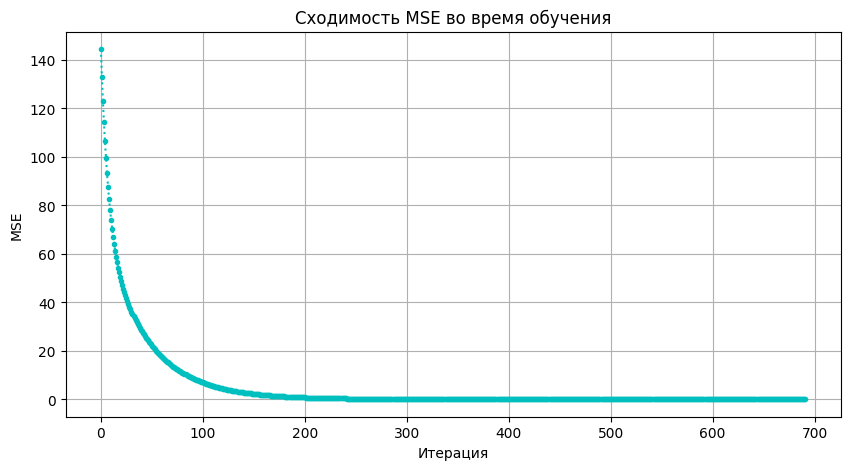

In [6]:
model = LinearRegression(degree=3)
model.train(x_train, y_train)

mseHistory = model.getHistory()
plt.figure(figsize=(10, 5))
plt.plot(mseHistory, marker='.', linestyle=':', color='c')
plt.title('Сходимость MSE во время обучения')
plt.xlabel('Итерация')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

### Оценка качества линейной модели

In [7]:
y_pred = model.predict(x_test)
mse = np.mean((y_pred - y_test) ** 2)
print(f"MSE: {mse:.5f}")

MSE: 0.04519


### Визуализация модели

График показывает зависимость признаков объекта, созданных в промежутке от минимального и максимального значения признаков. Он зависит от полученных весов, а не от исходных значений признаков объекта  

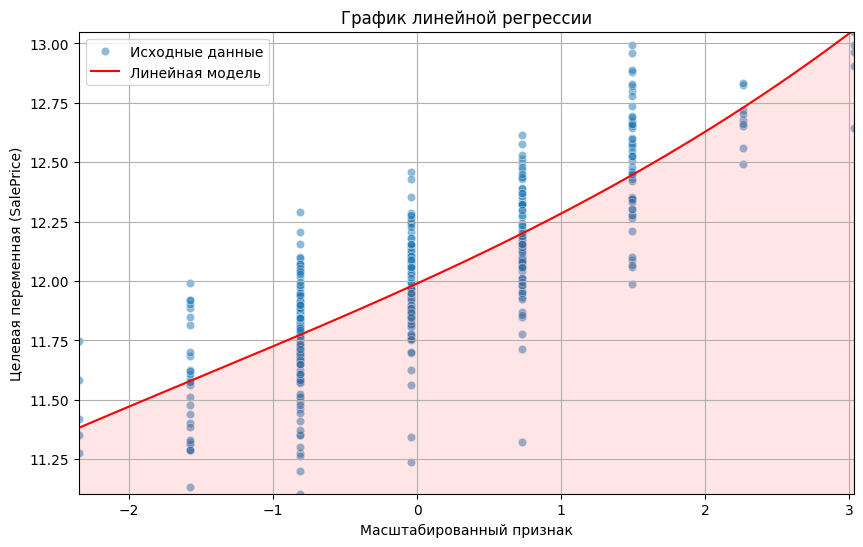

In [8]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x=x_test.ravel(), y=y_test.ravel(), alpha=0.5, label="Исходные данные")

x_range = np.linspace(min(x_test), max(x_test), 500).reshape(-1, 1) 
y_range = model.predict(x_range)
plt.plot(x_range.ravel(), y_range, color='red', label="Линейная модель")
plt.fill_between(x_range.ravel(), y_range, color='red', alpha=0.1)

plt.title("График линейной регрессии")
plt.xlabel("Масштабированный признак")
plt.ylabel("Целевая переменная (SalePrice)")
plt.legend()
plt.grid(True)

plt.xlim(min(x_test), max(x_test))
plt.ylim(min(y_test), max(y_test))
plt.show()

## 3. Аналитическая модель

$$
\text{W} = (X^T \cdot X)^{-1} \cdot X^T \cdot Y
$$

In [9]:
class LinearRegressionAnalytical:
  def __init__(self, degree=1):
    self.degree = degree
    self.weights = None
    
  def addIntercept(self, X):  
    intercept = np.ones((X.shape[0], 1))
    return np.concatenate([intercept, X], axis=1)
    
  def addPolynomialFeatures(self, X):
    if self.degree <= 1:
        return X 
    polyFeatures = [X ** i for i in range(1, self.degree + 1)]
    return np.hstack(polyFeatures)
        
  def train(self, X, Y):
    X = self.addPolynomialFeatures(X)
    X = self.addIntercept(X)
    self.weights = np.linalg.inv(X.T @ X) @ X.T @ Y
    
  def predict(self, X):
    X = self.addPolynomialFeatures(X)
    X = self.addIntercept(X)
    return X @ self.weights

### Оценка качества линейной модели

In [10]:
model = LinearRegressionAnalytical(degree=4)
model.train(x_train, y_train)

y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.5f}")

MSE: 0.04475


### Визуализация модели

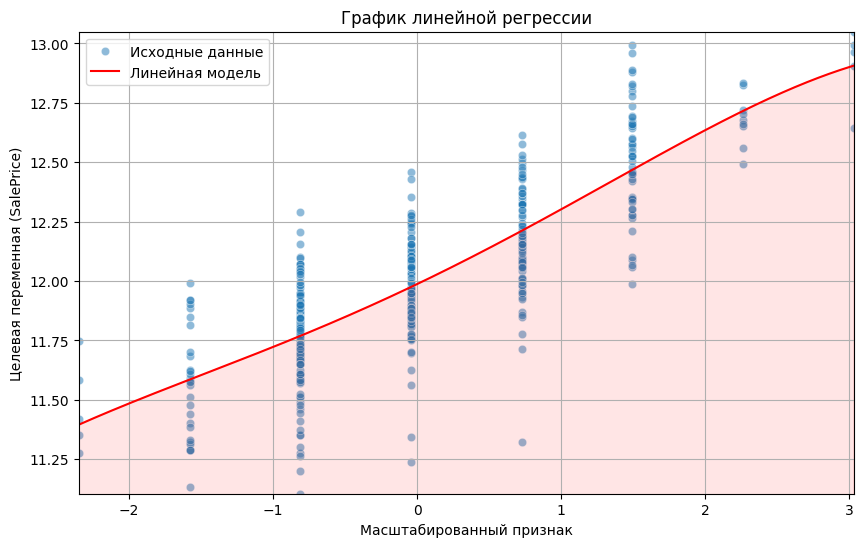

In [11]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x=x_test.ravel(), y=y_test.ravel(), alpha=0.5, label="Исходные данные")

x_range = np.linspace(min(x_test), max(x_test), 500).reshape(-1, 1) 
y_range = model.predict(x_range)
plt.plot(x_range.ravel(), y_range, color='red', label="Линейная модель")
plt.fill_between(x_range.ravel(), y_range, color='red', alpha=0.1)

plt.title("График линейной регрессии")
plt.xlabel("Масштабированный признак")
plt.ylabel("Целевая переменная (SalePrice)")
plt.legend()
plt.grid(True)

plt.xlim(min(x_test), max(x_test))
plt.ylim(min(y_test), max(y_test))
plt.show()